<a href="https://colab.research.google.com/github/TanviSingh01/Good-Light-For-Working/blob/master/Copy_of_sig_similarity_sigmoid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
print(tf.__version__)


2.3.0


# Visualize the data for few sample images

forged: 1
same: 0

In [ ]:
import keras
import numpy as np
import pandas as pd
from keras import backend as K
import random
import os
import cv2
from random import shuffle



path = "/content/drive/My Drive/sign_data"

def create_pairs(data_frame, path, type_="train"):
    pairs = []
    labels = []
    counter = 0

    for index, row in data_frame.iterrows():
        # print("Image Count: {}".format(counter))
        image1_path = os.path.join(path, type_, row["img1"])
        image1 = cv2.imread(image1_path)
        image1_gray = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
        image1 = cv2.resize(image1_gray,(105, 105))
        # image1 = image1/255.0

        image2_path = os.path.join(path, type_, row["img2"])
        image2 = cv2.imread(image2_path)
        image2_gray = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)
        image2 = cv2.resize(image2_gray,(105, 105))
        # image2 = image2/255.0

        print(image1_path)
        print(image2_path)
        print(row["label"])
        print("***********************************************")

        labels += [int(row["label"])]
        pairs += [[image1, image2]]
        if counter == 5:
            break
        counter += 1

    return np.array(pairs), np.array(labels)


train_csv_path = os.path.join(path, "train_data.csv")
print("train_data.csv read")
train_df = pd.read_csv(train_csv_path, names=["img1","img2","label"])
#train_df = shuffle(train_df)
train_pairs, train_y = create_pairs(train_df, path, type_="train")



train_data.csv read


FileNotFoundError: ignored

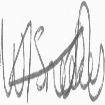

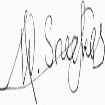

**************************


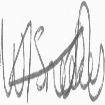

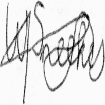

**************************


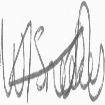

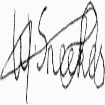

**************************


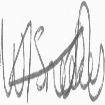

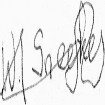

**************************


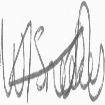

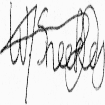

**************************


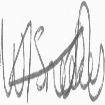

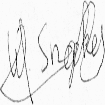

In [ ]:
from google.colab.patches import cv2_imshow
cv2_imshow(train_pairs[:,0][0])
cv2_imshow(train_pairs[:,1][0])
print("**************************")
cv2_imshow(train_pairs[:,0][1])
cv2_imshow(train_pairs[:,1][1])
print("**************************")
cv2_imshow(train_pairs[:,0][2])
cv2_imshow(train_pairs[:,1][2])
print("**************************")
cv2_imshow(train_pairs[:,0][3])
cv2_imshow(train_pairs[:,1][3])
print("**************************")
cv2_imshow(train_pairs[:,0][4])
cv2_imshow(train_pairs[:,1][4])
print("**************************")
cv2_imshow(train_pairs[:,0][5])
cv2_imshow(train_pairs[:,1][5])

**Visualizing the shape of each image in each pair**


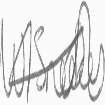

*************************************


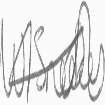

*************************************


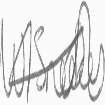

*************************************


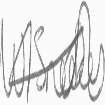

*************************************


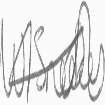

*************************************


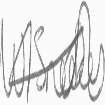

*************************************


In [ ]:
train_pairs[:, 0].reshape(-1, 105,105, 1).shape
cv2_imshow(train_pairs[:, 0].reshape(-1, 105,105, 1)[0])
print("*************************************")
cv2_imshow(train_pairs[:, 0].reshape(-1, 105,105, 1)[1])
print("*************************************")
cv2_imshow(train_pairs[:, 0].reshape(-1, 105,105, 1)[2])
print("*************************************")
cv2_imshow(train_pairs[:, 0].reshape(-1, 105,105, 1)[3])
print("*************************************")
cv2_imshow(train_pairs[:, 0].reshape(-1, 105,105, 1)[4])
print("*************************************")
cv2_imshow(train_pairs[:, 0].reshape(-1, 105,105, 1)[5])
print("*************************************")

# Creating the CNN Model


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


1. Created a Siamese Network for to find out the Image similarity(here images are having signatures and a image pair is given as input to the network)   
2. Took sigmoid layer as the last layer to find out probablity of being similar(is of now I kept the threshold as 0.5)
3. Took absolute difference between the two encoded vectors(one for each image in pair)
4. Took "Binary CrossEntropy" as a loss funtion(binary classification of signature being forged or not)
5. This model will give you the probability score of images being forged.
6. Able to get around 99% accuracy on validation data.







In [ ]:

import keras
from keras.layers import Conv2D, Dropout, Flatten, Dense, MaxPooling2D, SpatialDropout2D, Lambda, Input, BatchNormalization
from keras.models import Model
import numpy as np
import pandas as pd
from keras import backend as K
import random
import os
import cv2
from keras.optimizers import SGD
from sklearn.utils import shuffle
import tensorflow as tf

num_classes = 2
epochs = 50
path = "/content/drive/My Drive/sign_data"

sgd = SGD(lr=0.01)

input_shape=(105, 105, 1)


def create_pairs(data_frame, path, type_="train"):
    pairs = []
    labels = []
    counter = 0

    for index, row in data_frame.iterrows():
        # print("Image Count: {}".format(counter))
        image1_path = os.path.join(path, type_, row["img1"])
        image1 = cv2.imread(image1_path)
        image1_gray = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
        image1 = cv2.resize(image1_gray,(105, 105))
        image1 = image1/255.0

        image2_path = os.path.join(path, type_, row["img2"])
        image2 = cv2.imread(image2_path)
        image2_gray = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)
        image2 = cv2.resize(image2_gray,(105, 105))
        image2 = image2/255.0

        labels += [int(row["label"])]
        pairs += [[image1, image2]]
        # counter += 1

    return np.array(pairs), np.array(labels)
  
def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))

def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

def compute_accuracy(y_true, y_pred):
    pred = y_pred.ravel() > 0.5
    return np.mean(pred == y_true)

def accuracy(y_true, y_pred):
    return K.mean(K.equal(y_true, K.cast(y_pred > 0.5, y_true.dtype)))

def contrastive_loss(y_true, y_pred):
    margin = 1
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)


train_csv_path = os.path.join(path, "train_data.csv")
print("train_data.csv read")
train_df = pd.read_csv(train_csv_path, names=["img1","img2","label"])
train_df = shuffle(train_df)
train_pairs, train_y = create_pairs(train_df, path, type_="train")
print("Training Pairs Created")
print("Train data shape is: ", train_pairs.shape)


test_csv_path = os.path.join(path, "test_data.csv")
print("test_data.csv read")
test_df = pd.read_csv(test_csv_path, names=["img1","img2","label"])
test_df = shuffle(test_df)
test_pairs, test_y = create_pairs(test_df, path, type_="test")
print("Testing Pairs Created")
print("Test data shape is: ", test_pairs.shape)


left_input = Input(shape=input_shape)
right_input = Input(shape=input_shape)

base_model  = keras.Sequential()

base_model.add(Conv2D(96, kernel_size=3, input_shape=input_shape, strides=1, activation="relu"))
base_model.add(MaxPooling2D(pool_size=3, strides=2))
# base_model.add(SpatialDropout2D(rate=0.1))

base_model.add(Conv2D(256, kernel_size=1, strides=1, activation="relu"))
base_model.add(MaxPooling2D(pool_size=3, strides=2))
base_model.add(BatchNormalization())
base_model.add(SpatialDropout2D(rate=0.1))


base_model.add(Flatten())
base_model.add(Dense(512, activation='relu'))
base_model.add(Dropout(rate=0.5))

base_model.add(Dense(64, activation="relu"))
base_model.add(Dropout(rate=0.5))
base_model.add(Dense(1, activation='sigmoid'))

encoded_l = base_model(left_input)
encoded_r = base_model(right_input)

L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
L1_distance = L1_layer([encoded_l, encoded_r])

prediction = Dense(1,activation='sigmoid')(L1_distance)
model = Model(inputs=[left_input,right_input],outputs=prediction)

early_stopping_callback=tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100)

model.compile(loss="binary_crossentropy", optimizer=sgd, metrics=[accuracy])
print(model.summary())

model_history = model.fit([train_pairs[:, 0].reshape(-1, 105,105, 1), train_pairs[:, 1].reshape(-1, 105, 105, 1)], train_y,
          batch_size=128,
          epochs=epochs,
          validation_data=([test_pairs[:, 0].reshape(-1, 105,105, 1), test_pairs[:, 1].reshape(-1, 105, 105, 1)], test_y), callbacks=[early_stopping_callback])

model.save(os.path.join(path,'signature_similarity_model_sigmoid.h5'))



import matplotlib.pyplot as plt
# summarize history for accracy
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig(os.path.join(path,"accuracy_sigmoid.png"))
plt.close()

# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig(os.path.join(path,"loss_sigmoid.png"))
plt.close()



train_data.csv read


FileNotFoundError: ignored

In [ ]:
import keras
from keras.layers import Conv2D, Dropout, Flatten, Dense, MaxPooling2D, SpatialDropout2D, Lambda, Input, BatchNormalization
from keras.models import Model
import numpy as np
import pandas as pd
from keras import backend as K
import random
import os
import cv2
from keras.optimizers import SGD

path_in_model = "/content/drive/My Drive/sign_data"

def create_pairs(data_frame, path,type_):
    pairs = []
    labels = []
    images = []

    for index, row in data_frame.iterrows():
        image1_path = os.path.join(path, type_, row["img1"])
        image2_path = os.path.join(path, type_, row["img2"])
        print(image1_path)
        if (os.path.isfile(image1_path) and os.path.isfile(image2_path)):
            print('images found!')
            image1 = cv2.imread(image1_path)
            image1_gray = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
            image1 = cv2.resize(image1_gray,(105, 105))
            image1 = image1/255.0

            image2 = cv2.imread(image2_path)
            image2_gray = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)
            image2 = cv2.resize(image2_gray,(105, 105))
            image2 = image2/255.0

            labels += [int(row["label"])]
            pairs += [[image1, image2]]
            images += [[str(row["img1"]), str(row["img2"])]]
            
            

    return np.array(pairs), np.array(labels), np.array(images)

def use_model(data_pairs, images):
    print('Here:')
    model = keras.models.load_model(os.path.join(path_in_model, 'signature_similarity_model_sigmoid.h5'))
    print('Model:'+str(model))
    predictions = model.predict([data_pairs[:, 0].reshape(-1, 105,105, 1), data_pairs[:, 1].reshape(-1, 105,105, 1)])
    rounded = [(x[0]) for x in predictions]
    print('Here!')

    for i in range(len(tuids)):
        print('%s => %d' % (tuids[i], predictions[i]))
    
    

# --------------------------------------------------------------------------- #
if __name__ == "__main__":  
    path = "/content/drive/My Drive/sign_data"
    type_ = "train"
    test_csv_path = os.path.join(path, "test_data.csv")
    print("test_data.csv read")  
    train_csv_path = os.path.join(path, "train_data.csv")
    print("train_Data.csv read")
    train_df = pd.read_csv(train_csv_path, names=["img1","img2","label"])
    train_pairs, train_y, tuids = create_pairs(train_df, path, type_)
    print("Training Pairs Created")
    print("Train data shape is: ", train_pairs.shape)
    use_model(train_pairs, tuids)
    


Streaming output truncated to the last 5000 lines.
['015/015_19.PNG' '015_forg/0106015_02.png'] => 0
['015/015_19.PNG' '015_forg/0213015_03.png'] => 0
['015/015_19.PNG' '015_forg/0213015_01.png'] => 0
['015/015_19.PNG' '015_forg/0210015_02.png'] => 0
['015/015_19.PNG' '015_forg/0210015_04.png'] => 0
['015/015_19.PNG' '015_forg/0106015_01.png'] => 0
['015/015_19.PNG' '015_forg/0213015_04.png'] => 0
['015/015_19.PNG' '015_forg/0210015_03.png'] => 0
['015/015_13.PNG' '015_forg/0106015_04.png'] => 0
['015/015_13.PNG' '015_forg/0213015_02.png'] => 0
['015/015_13.PNG' '015_forg/0106015_03.png'] => 0
['015/015_13.PNG' '015_forg/0210015_01.png'] => 0
['015/015_13.PNG' '015_forg/0106015_02.png'] => 0
['015/015_13.PNG' '015_forg/0213015_03.png'] => 0
['015/015_13.PNG' '015_forg/0213015_01.png'] => 0
['015/015_13.PNG' '015_forg/0210015_02.png'] => 0
['015/015_13.PNG' '015_forg/0210015_04.png'] => 0
['015/015_13.PNG' '015_forg/0106015_01.png'] => 0
['015/015_13.PNG' '015_forg/0213015_04.png'] => 0

# Future Work


1. We can break(length wise or width wise) the image in to certain fixed number of vectors and train a sequencial model to learn the pattern of writings of a particular person as every person's writing style and writing caliberation is different.
2. We can use the tripplet loss make more stable model.
3. We can do experiments with hyperparameter tuning and various model architectures to make a more robust model.